In [1]:
en_dir="/home/apsisdev/ansary/DATASETS/EnNums/"
bn_dir="/home/apsisdev/ansary/DATASETS/BnNums/"
save_dir="/home/apsisdev/ansary/DATASETS/APSIS/CDR/datasets/num/"
styles_csv="/home/apsisdev/ansary/CODES/apsis-cdr-ocr/tests/styles/data.csv"

In [2]:
import sys
sys.path.append("../")
import os 
import numpy as np
import cv2
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot  as plt
tqdm.pandas()
import random
from coreLib.processing import correctPadding
from coreLib.utils import create_dir
en_vocab=["0","1","2","3","4","5","6","7","8","9"]
bn_vocab=['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']

def random_exec(poplutation=[0,1],weights=[0.5,0.5],match=0):
    return random.choices(population=poplutation,weights=weights,k=1)[0]==match

def get_df_dict(_dir,vocab):
    csv=os.path.join(_dir,"data.csv")
    df=pd.read_csv(csv)
    df.label=df.label.progress_apply(lambda x:str(x))
    df_dict={}
    for v in vocab:
        vdf=df.loc[df.label==v]
        vdf.reset_index(inplace=True,drop=True)
        df_dict[v]=vdf
    return df_dict

def get_rand_img_path(df_dict,comp):
    df=df_dict[comp]
    idx=random.randint(0,len(df)-1)
    return df.iloc[idx,0]

def padAllAround(img,pad_dim,pad_val,pad_single=None):
    '''
        pads all around the image
    '''
    if pad_single is None:
        h,w=img.shape
        # pads
        left_pad =np.ones((h,pad_dim))*pad_val
        right_pad=np.ones((h,pad_dim))*pad_val
        # pad
        img =np.concatenate([left_pad,img,right_pad],axis=1)
        # shape
        h,w=img.shape
        top_pad =np.ones((pad_dim,w))*pad_val
        bot_pad=np.ones((pad_dim,w))*pad_val
        # pad
        img =np.concatenate([top_pad,img,bot_pad],axis=0)
    elif pad_single=="tb":
        # shape
        h,w=img.shape
        top_pad =np.ones((pad_dim,w))*pad_val
        bot_pad=np.ones((pad_dim,w))*pad_val
        # pad
        img =np.concatenate([top_pad,img,bot_pad],axis=0)
    else:
        h,w=img.shape
        # pads
        left_pad =np.ones((h,pad_dim))*pad_val
        right_pad=np.ones((h,pad_dim))*pad_val
        # pad
        img =np.concatenate([left_pad,img,right_pad],axis=1)
    return img

def create_labeled_box(num_box):
    labeled=[]
    bsize=random.randint(64,96)
    side=random.randint(0,10)
    thickness=random.randint(2,8)
    pad=random.randint(2,5)
    for i in range(num_box):
        iden=i+2
        box=np.ones((bsize,bsize))*iden
        box=padAllAround(box,thickness,0)
        box=padAllAround(box,pad,1)
        labeled.append(box)
    box=np.concatenate(labeled,axis=-1)
    if random_exec():
        box=padAllAround(box,side,1,pad_single="tb")
    return  box.astype("uint8")

def randColor(col=True):
    '''
        generates random color
    '''
    if col:
        return (random.randint(0,255),random.randint(0,255),random.randint(0,255))
    else:
        d=random.randint(0,64)
        return (d,d,d)

def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = random.randint(1,2)/10
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    
    return noisy

styles=pd.read_csv(styles_csv)
styles=styles.loc[styles.data!="name"]
styles.reset_index(drop=True,inplace=True)
styles

,filepath,word,data
0,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,29,age
1,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,01935698629,mobile
2,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,50,age
3,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,01713566560,mobile
4,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,29,age
...,...,...,...
7926,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,01910895380,mobile
7927,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,50,age
7928,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,01713566560,mobile
7929,/home/apsisdev/ansary/CODES/apsis-cdr-ocr/test...,২৭,age


100%|██████████| 70000/70000 [00:00<00:00, 1526803.61it/s]


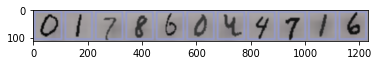

In [3]:
def create_number_image(df_dict,data):
    cimgs=[cv2.imread(get_rand_img_path(df_dict,c)) for c in data]
    box_map=create_labeled_box(len(data))
    midxs=sorted(np.unique(box_map))[2:]

    h,w=box_map.shape
    mask=np.zeros_like(box_map)
    sid=random.randint(0,len(styles)-1)
    img=cv2.imread(styles.iloc[sid,0])
    img=cv2.resize(img,(w,h))
    img=cv2.blur(img,(50,50)) 
    
    img[box_map==0]=randColor()
    #
    
    for cimg,midx in zip(cimgs,midxs):
        # placement
        idx = np.where(box_map==midx)                
        x_min,x_max = np.min(idx[1]), np.max(idx[1])
        y_min,y_max=0,h
        cw=x_max-x_min
        
        # fix
        grey=cv2.cvtColor(cimg,cv2.COLOR_BGR2GRAY)
        _,cbin = cv2.threshold(grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        cimg=cv2.resize(cimg,(cw,h))
        cbin=cv2.resize(cbin,(cw,h),fx=0,fy=0,interpolation=cv2.INTER_NEAREST)
        
        cback=img[y_min:y_max,x_min:x_max]
        cimg[cbin>0]=cback[cbin>0]
        cimg[cbin==0]=randColor(col=False)
        img[y_min:y_max,x_min:x_max]=cimg

    #img[box_map==0]=back[box_map==0]
    img=cv2.blur(img,(5,5)) 
    img=img.astype("uint8")
    return img
data="01786044716"
df_dict=get_df_dict(en_dir,en_vocab)
plt.imshow(create_number_image(df_dict,data))

In [4]:
num_samples=100000
img_dir=create_dir(save_dir,"images")
data_csv=os.path.join(save_dir,"data.csv")
words=[]
labels=[]
masks=[]
filepaths=[]
max_len=15

In [5]:


_vocab=en_vocab
_dir=en_dir
df_dict=get_df_dict(_dir,_vocab)


for i in tqdm(range(num_samples)):
    try:
        if random_exec(weights=[0.65,0.35]):
            dlen=11
        else:
            if random_exec(weights=[0.65,0.35]):
                dlen=2
            else:
                dlen=random.randint(3,10)
        label="".join([random.choice(_vocab) for _ in range(dlen)])
        #d-w
        words.append(label)

        img=create_number_image(df_dict,label)
        # d-f
        filepath=os.path.join(img_dir,f"en{i}.png")
        cv2.imwrite(filepath,img)
        filepaths.append(filepath)
        
    except Exception as e:
        print(e)




100%|██████████| 70000/70000 [00:00<00:00, 1478779.31it/s]


  0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
_vocab=bn_vocab
_dir=bn_dir
df_dict=get_df_dict(_dir,_vocab)

for i in tqdm(range(num_samples)):
    try:
        if random_exec(weights=[0.65,0.35]):
            dlen=11
        else:
            if random_exec(weights=[0.65,0.35]):
                dlen=2
            else:
                dlen=random.randint(3,10)
        label="".join([random.choice(_vocab) for _ in range(dlen)])
        #d-w
        words.append(label)

        img=create_number_image(df_dict,label)
        # d-f
        filepath=os.path.join(img_dir,f"bn{i}.png")
        cv2.imwrite(filepath,img)
        filepaths.append(filepath)
    except Exception as e:
        print(e)


df=pd.DataFrame({"filepath":filepaths,"word":words})
df=df.sample(frac=1)
df.to_csv(data_csv,index=False)
df

100%|██████████| 102875/102875 [00:00<00:00, 1655815.74it/s]


  0%|          | 0/100000 [00:00<?, ?it/s]

,filepath,word
195415,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,৬৩
56161,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,21040837954
126893,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,৬১
99813,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,8632
62222,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,74
...,...,...
107813,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,২৯২০৯৯৬৬৯৬৫
103678,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,৪৪
63835,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,03
162559,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,৫১


In [8]:
# convert labels
def change_labels(x):
    bnn=['০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯']
    x=str(x)
    for b in bnn:
        x=x.replace(b,str(bnn.index(b)))
    return x
df.word=df.word.progress_apply(lambda x:change_labels(x))
df

100%|██████████| 200000/200000 [00:00<00:00, 326961.07it/s]


,filepath,word
195415,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,63
56161,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,21040837954
126893,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,61
99813,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,8632
62222,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,74
...,...,...
107813,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,29209966965
103678,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,44
63835,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,03
162559,/home/apsisdev/ansary/DATASETS/APSIS/CDR/datas...,51


In [9]:
df.to_csv(data_csv,index=False)

In [7]:

# import os 
# import json
# import math
# import pandas as pd 
# import tensorflow as tf
# import numpy as np 
# from ast import literal_eval
# from tqdm.auto import tqdm
# tqdm.pandas()
# #---------------------------------------------------------------
# # data functions
# #---------------------------------------------------------------
# cols=["filepath","label","word","mask"]
# eval_cols=["label"]
    
# # feature fuctions
# def _bytes_feature(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
# def _int64_list_feature(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


# def toTfrecord(df,rnum,rec_path):
#     '''
#         args:
#             df      :   the dataframe that contains the information to store
#             rnum    :   record number
#             rec_path:   save_path
#             mask_dim:   the dimension of the mask
#     '''
#     tfrecord_name=f'{rnum}.tfrecord'
#     tfrecord_path=os.path.join(rec_path,tfrecord_name) 
#     with tf.io.TFRecordWriter(tfrecord_path) as writer:    
        
#         for idx in range(len(df)):
#             # base
#             img_path=df.iloc[idx,0]
#             # img
#             with(open(img_path,'rb')) as fid:
#                 image_png_bytes=fid.read()
#             # feature desc
#             data ={ 'image':_bytes_feature(image_png_bytes)}

#             for cidx,col in enumerate(cols):
#                 if col in eval_cols:
#                     data[col]=_int64_list_feature(df.iloc[idx,cidx]) 

            
#             features=tf.train.Features(feature=data)
#             example= tf.train.Example(features=features)
#             serialized=example.SerializeToString()
#             writer.write(serialized)  

# def createRecords(data,save_path,tf_size=10240):
#     '''
#         creates tf records:
#         args:
#             data        :   either the csv path or a dataframe
#             save_path   :   location to save tfrecords
#     '''
#     if type(data)==str:
#         data=pd.read_csv(data)
#         for col in eval_cols:
#             data[col]=data[col].progress_apply(lambda x: literal_eval(x))
    
#     for idx in tqdm(range(0,len(data),tf_size)):
#         df        =   data.iloc[idx:idx+tf_size]  
#         rnum      =   idx//tf_size
#         toTfrecord(df,rnum,save_path)

    
    

In [8]:
# lang_dir=create_dir(save_dir,"english")
# rec_dir=create_dir(lang_dir,"tfrecords")
# data=os.path.join(lang_dir,"data.csv")
# createRecords(data,rec_dir)

In [9]:
# lang_dir=create_dir(save_dir,"bangla")
# rec_dir=create_dir(lang_dir,"tfrecords")
# data=os.path.join(lang_dir,"data.csv")
# createRecords(data,rec_dir)

In [10]:
# formulate robust scanner as backup

In [11]:
# # classification
# bn=os.path.join(save_dir,"bangla","data.csv")
# en=os.path.join(save_dir,"english","data.csv")
# bn=pd.read_csv(bn)
# en=pd.read_csv(en)
# bn=bn.sample(frac=1)
# bn.reset_index(inplace=True,drop=True)
# en=en.sample(frac=1)
# en.reset_index(inplace=True,drop=True)
# bn=bn[:100000]
# en=en[:100000]
# df=pd.concat([bn,en],ignore_index=True)
# df=df.sample(frac=1)
# df.reset_index(inplace=True,drop=True)
# df

In [12]:
# df=df[["filepath","word","mask"]]
# df

In [13]:
# df.to_csv("data.csv",index=False)

In [14]:
# pos_max=40
# from coreLib.languages import vocab
# from coreLib.processing import processLabels
# df.word=df.word.progress_apply(lambda x:str(x))
# df=processLabels(df,vocab,pos_max)
# # save data
# cols=["filepath","mask","label"]
# df=df[cols]
# df.dropna(inplace=True)


In [15]:
# df

In [16]:
# import math
# def convertMask(x):
#     imask=math.ceil((x/512)*(512//32))
#     mask=np.zeros((64//32,512//32))
#     mask[:,:imask]=1
#     mask=mask.flatten().tolist()
#     mask=[int(i) for i in mask]
#     return mask


In [17]:
# df["mask"]=df["mask"].progress_apply(lambda x: convertMask(x))
# df

In [18]:
# save_dir="/home/apsisdev/ansary/DATASETS/APSIS/CDR/datasets/numbers/tfrecords/"
# from coreLib.store import createRecords
# createRecords(df,save_dir)